In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

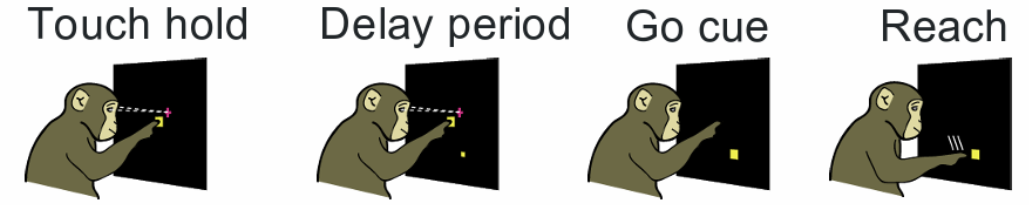

In [2]:
with open('datos_disparos_mono_tp2.npz', 'rb') as loadfile:
    spike_times = np.load(loadfile, allow_pickle=True)['spike_times'] #shape = 1127 episodios, 190 neuronas, nro de disparos (variable).
                                                                      #Recomendamos mirar len(spike_times), len(spike_times[n]), etc. para entender bien los datos

with open('metadata_mono_tp2.npy', 'rb') as loadfile:
    metadata = np.load(loadfile)
    time_touch_held = metadata['time_touch_held'] # tiempos de aparición del target para cada episodio
    time_go_cue = metadata['time_go_cue'] # tiempo de señal de GO (comienzo del movimiento) para cada episodio
    time_target_acquired = metadata['time_target_acquired'] # tiempo en que el objetivo fue tocado para cada episodio
    trial_reach_target = metadata['trial_reach_target'] # índice de a que target tenía que ir para cada episodio (0 a 7)
    target_locations = metadata['target_locations'] #  posición x,y de cada target
    target_angles = metadata['target_angles'] # ángulo de cada target

len(spike_times), len(spike_times[0])

(1127, 190)

In [3]:
def extract_plan_spikes(window_length=None,
                        start_offset=None):
    # Devuelve una matriz de conteos de disparos en la ventana de planificación
    # - La ventana de planificación default está definida como el tiempo
    #   entre time_touch_held y time_go_cue para cada episodio.
    #   NOTA: no todos los episodios tienen la misma duración!
    # - Si se especifica una "window_length" (longitud de ventana), devuelve el número
    #   de disparos en la ventana para esa duración. Retorna -1 si el periodo de planificación
    #   es demasiado corto para la ventana (ej. si window_length=1000 pero el periodo de
    #   planificación era 755ms)
    # - Si se especifica un "start_offset", retorna el número de disparos en la ventana
    #   que empieza "start_offset" ms después de time_touch_held (y usa time_go_cue o la
    #   window_length opcional para determinar el final de la ventana). Si start_offset
    #   es tan grande que se extiende más que time_go_cue, retorna -1

    if start_offset:
        trial_starts = time_touch_held + start_offset
    else:
        trial_starts = time_touch_held

    plan_spikes = []
    for tx, trialSpikes in enumerate(spike_times):#Para cada una de las neuronas (o más bien, para cada tren de disparo, que c/u pertenece a una neurona)
        if window_length:
            trial_end = trial_starts[tx] + window_length
        else:
            trial_end = time_go_cue[tx]

        if (trial_end < trial_starts[tx]):
            raise ValueError("El final del episodio (trial_end) es menor que el comienzo (trial_starts)")
                # plan_spikes.append(-np.ones(len(trialSpikes)))
        elif (trial_end > time_go_cue[tx]):
            raise ValueError("El final del episodio (trial_end) es menor que el final del periodo de planificación (time_go_cue)")
        else:
            plan_spikes.append(#Sim
                np.array([np.sum((st > trial_starts[tx]) &
                        (st < trial_end)) for st in trialSpikes]))#Contamos cuantos disparos hubo en esa ventana!
    return np.array(plan_spikes) # debería ser de 1127 x 190 (nro de episodios x nro de neuronas)

In [4]:
def multivariate_poisson_logpdf(mu, x, mean_eps=0.01):
    # asume mu es dimensión (N,) y x es (d,N)
    mu2 = mu
    mu2[np.argwhere(mu < mean_eps)] = mean_eps # setea un promedio de disparos muy bajitos para los que daban 0 para evitar que tenga probabilidad 0
    return np.sum(x * np.log(mu2) - mu2, axis=1)

In [7]:
# Inicializamos el DataFrame para almacenar los resultados
results_df = pd.DataFrame()

# Seleccionamos neuronas al azar
target_size =  [5, 10, 15, 20, 25, 30, 35, 40]
for target in target_size:
    plan_spikes = extract_plan_spikes(window_length=250, start_offset=100) # 250ms de ventana, 100ms de desfasaje
    iteration_results = [] 

    for i in range(50):

        # Armamos seleccionar los sets de entrenamiento y testeo al azar
        training_trials = [] # van a ser 8 listas de episodios (una para cada clase)
        test_trials = [] # todos los que sobran
        for c in range(8): # targets del 0 al 7
            target_trials = np.argwhere(trial_reach_target==c).squeeze()

            # seleccionar 25 episodios al azar (por cada dirección)
            random_training_trials = np.random.choice(target_trials, target, replace=False)
            training_trials.append(random_training_trials)
            remaining_test_trials = np.setdiff1d(target_trials, random_training_trials)

            test_trials.extend(remaining_test_trials)
        
        # Calculamos el nro promedio de disparos por neurona y target
        # Representa las medias de una distribución de Poisson 190-dimensional para cada una de las direcciones
        num_neurons = plan_spikes.shape[1]
        mean_spike_counts = np.zeros((num_neurons, 8)) # Notar que las dimensiones son 190 neuronas x 8 direcciones
        for c in range(8):
            mean_spike_counts[:,c] = np.mean(plan_spikes[training_trials[c],:], axis=0)

        # Calculamos la probabilidad para cada target y cada episodio (verosimilitud)
        poisson_likelihood = np.zeros((len(test_trials), 8))
        for c in range(8):
            m = mean_spike_counts[:,c]
            poisson_likelihood[:,c] = \
                multivariate_poisson_logpdf(m, plan_spikes[test_trials,:])
            
        # Decodificación y cálculo del porcentaje correcto
        correct_targets = trial_reach_target[test_trials] # target correcto para cada episodio
        decoded_targets = np.argmax(poisson_likelihood,axis=1) # el target decodificado es el que nos dá la mayor verosimilitud!
        
        correct_percentage = np.mean(correct_targets == decoded_targets)
        iteration_results.append(correct_percentage)

    results_df['{} samples for target'.format(target)] = iteration_results

results_df = results_df.transpose()
results_df['Average'] = results_df.mean(axis=1)
results_df.style.background_gradient(cmap='RdYlGn',subset=["Average"])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,Average
5 samples for target,0.740570,0.775529,0.793008,0.735971,0.760810,0.751610,0.753450,0.752530,0.770009,0.751610,0.762649,0.708372,0.711132,0.711132,0.752530,0.726771,0.763569,0.758050,0.802208,0.714811,0.786569,0.827047,0.779209,0.759890,0.779209,0.761730,0.757130,0.831647,0.747010,0.772769,0.767249,0.753450,0.746090,0.781049,0.771849,0.701012,0.731371,0.741490,0.758970,0.769089,0.801288,0.768169,0.761730,0.793008,0.748850,0.776449,0.778289,0.735051,0.795768,0.712971,0.759834
10 samples for target,0.787011,0.814709,0.802292,0.862464,0.784145,0.809933,0.841452,0.818529,0.841452,0.849093,0.805158,0.865330,0.820439,0.812798,0.823305,0.823305,0.843362,0.864374,0.826170,0.807068,0.852913,0.826170,0.838586,0.835721,0.801337,0.867240,0.847182,0.804202,0.856734,0.851003,0.807068,0.814709,0.791786,0.827125,0.786055,0.815664,0.831901,0.823305,0.817574,0.804202,0.822350,0.870105,0.869150,0.828080,0.847182,0.831901,0.817574,0.862464,0.861509,0.837631,0.829016
15 samples for target,0.826216,0.866931,0.839126,0.861966,0.835154,0.842105,0.853029,0.841112,0.826216,0.829196,0.872890,0.839126,0.867925,0.859980,0.855015,0.858987,0.853029,0.878848,0.865938,0.861966,0.907646,0.840119,0.830189,0.859980,0.835154,0.862959,0.881827,0.873883,0.861966,0.863952,0.833168,0.856008,0.862959,0.854022,0.875869,0.890765,0.861966,0.859980,0.870904,0.835154,0.823237,0.862959,0.863952,0.896723,0.834161,0.867925,0.846077,0.871897,0.831182,0.846077,0.855948
20 samples for target,0.873837,0.883144,0.863495,0.871768,0.896587,0.886246,0.874871,0.889349,0.893485,0.913133,0.877973,0.855222,0.842813,0.881075,0.907963,0.862461,0.887280,0.865564,0.872802,0.869700,0.900724,0.895553,0.896587,0.886246,0.873837,0.871768,0.873837,0.865564,0.884178,0.881075,0.865564,0.850052,0.899690,0.854188,0.872802,0.911065,0.859359,0.842813,0.867632,0.856256,0.865564,0.887280,0.876939,0.876939,0.845915,0.895553,0.914168,0.868666,0.875905,0.859359,0.876877
25 samples for target,0.897519,0.877023,0.893204,0.861920,0.900755,0.912621,0.877023,0.907228,0.866235,0.894283,0.871629,0.871629,0.900755,0.870550,0.852211,0.922330,0.871629,0.860841,0.918015,0.870550,0.886731,0.877023,0.891046,0.898598,0.851133,0.903991,0.882416,0.886731,0.885653,0.873786,0.872708,0.908306,0.864078,0.894283,0.891046,0.889968,0.899676,0.884574,0.892125,0.914779,0.909385,0.868393,0.886731,0.860841,0.856526,0.901834,0.881338,0.858684,0.884574,0.882416,0.884746
30 samples for target,0.888388,0.871477,0.894025,0.898534,0.895152,0.895152,0.882751,0.903044,0.887260,0.880496,0.896280,0.889515,0.883878,0.875986,0.864713,0.879369,0.896280,0.853439,0.877114,0.886133,0.882751,0.871477,0.892897,0.888388,0.905299,0.901917,0.874859,0.878241,0.864713,0.882751,0.877114,0.859076,0.913191,0.880496,0.881623,0.878241,0.906426,0.861330,0.917700,0.915445,0.895152,0.891770,0.889515,0.888388,0.841037,0.874859,0.887260,0.889515,0.908681,0.881623,0.885614
35 samples for target,0.886659,0.913813,0.871311,0.911452,0.913813,0.906730,0.912633,0.906730,0.879575,0.893743,0.898465,0.892562,0.891381,0.912633,0.870130,0.886659,0.900826,0.896104,0.891381,0.910272,0.910272,0.893743,0.886659,0.906730,0.918536,0.890201,0.892562,0.902007,0.884298,0.900826,0.898465,0.898465,0.893743,0.883117,0.899646,0.892562,0.889020,0.904368,0.891381,0.876033,0.874852,0.879575,0.876033,0.871311,0.878394,0.891381,0.912633,0.886659,0.920897,0.887839,0.894782
40 samples for target,0.867410,0.892193,0.900867,0.921933,0.899628,0.924411,0.912020,0.898389,0.913259,0.897150,0.890954,0.909542,0.876084,0.890954,0.910781,0.909542,0.874845,0.908302,0.885998,0.869888,0.895911,0.914498,0.887237,0.919455,0.888476,0.871128,0.892193,0.910781,0.879802,0.894672,0.915737,0.888476,0.866171,0.863693,0.918216,0.888476,0.920694,0.898389,0.884758,0.885998,0.877323,0.907063,0.914498,0.883519,0.915737,0.899628,0.897150,0.898389,0.912020,0.907063,0.897026


Resumiendo el dataframe...

In [8]:
results_df = results_df.iloc[:, [-1]]
results_df.style.background_gradient(cmap='RdYlGn',subset=["Average"])

,Average
5 samples for target,0.759834
10 samples for target,0.829016
15 samples for target,0.855948
20 samples for target,0.876877
25 samples for target,0.884746
30 samples for target,0.885614
35 samples for target,0.894782
40 samples for target,0.897026


Por último, modificando la cantidad de muestras por target, podemos ver claramente como el modelo obtiene mejores resultados a medida que este número aumenta.